In [1]:
# !pip install prophet --upgrade

In [2]:
# !pip install sentence_transformers

In [3]:
# !pip install ace_tools

In [4]:
# !pip install Faker

# Import Libraries

In [5]:
# Import libraries and packages
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import random
import faker
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Sample Incident Dataset Creation

In [6]:
# Initialize Faker
fake = faker.Faker()

# Parameters
assignment_groups = ['LCH - Service1 - Support', 'LCH - Service2 - Support']
statuses = ['Completed', 'In-Progress', 'Cancelled']
priorities = ['P2', 'P3', 'P4']
date_range = pd.date_range(start="2018-10-01", end="2025-02-28", freq='W')

# Resolution notes templates
resolution_templates = {
    'Network': [
        "Network: VPN issue resolved by resetting tunnel configuration.",
        "Network: Switch firmware upgrade resolved packet loss.",
        "Network: DHCP reconfiguration fixed IP allocation."
    ],
    'Hardware': [
        "Hardware: Replaced faulty RAM module.",
        "Hardware: Cleaned fan assembly and updated BIOS.",
        "Hardware: Power unit replacement resolved the issue."
    ],
    'Software': [
        "Software: Patched application resolved crash issue.",
        "Software: Updated dependency libraries to resolve error.",
        "Software: Reinstalled software after registry clean-up."
    ],
    'Access': [
        "Access: Group membership updated in AD.",
        "Access: MFA reset completed for user login.",
        "Access: New role permissions assigned manually."
    ],
    'Database': [
        "Database: Cleared blocking session and restarted job.",
        "Database: Optimized SQL query to resolve timeout.",
        "Database: Table indexing completed to improve performance."
    ]
}

# Custom incident description generator
user_roles = ["analyst", "developer", "IT support", "finance user", "intern", "manager"]
locations = ["London office", "NY data center", "HR portal", "remote session", "VPN network"]
systems = ["CRM", "email gateway", "SSO", "VPN client", "data warehouse"]

def generate_variable_description(resolution_note):
    category = resolution_note.split(":")[0]
    role = random.choice(user_roles)
    location = random.choice(locations)
    system = random.choice(systems)
    variation = fake.sentence(nb_words=5)
    base_templates = {
        'Network': f"{role} reported network disruption at {location} affecting {system}. {variation}",
        'Hardware': f"{role}'s device at {location} showed signs of failure during diagnostics. {variation}",
        'Software': f"{role} experienced software crash while accessing {system} at {location}. {variation}",
        'Access': f"{role} unable to log into {system} from {location} environment. {variation}",
        'Database': f"{role} faced timeout error in {system} queries run from {location}. {variation}"
    }
    return base_templates.get(category, f"{role} encountered an issue in {system} at {location}. {variation}")

# Data generation
rows = []
incident_id = 100000
for date in date_range:
    month = date.month
    count = random.randint(35, 60) if month in [11, 12, 1] else random.randint(5, 15)
    for _ in range(count):
        group = random.choice(assignment_groups)
        status = random.choices(statuses, weights=[0.8, 0.15, 0.05])[0]
        priority = random.choices(priorities, weights=[0.05, 0.15, 0.8])[0]
        category = random.choice(list(resolution_templates.keys()))
        note = random.choice(resolution_templates[category])
        mttr = round(abs(np.random.normal(loc=10, scale=5)), 2)
        description = generate_variable_description(note)
        rows.append({
            "incident_number": f"INC{incident_id}",
            "assignment_group": group,
            "status": status,
            "resolution_notes": note,
            "MTTR": mttr,
            "Priority": priority,
            "created_date": date,
            "incident_description": description
        })
        incident_id += 1

# Create DataFrame and save to CSV
df = pd.DataFrame(rows)
df.to_csv("incident_dataset.csv", index=False)

# Import Incident Dataset & Exploratory Data Analysis

In [7]:
raw_data_df = pd.read_csv('incident_dataset.csv')

In [8]:
raw_data_df.head(2)

,incident_number,assignment_group,status,resolution_notes,MTTR,Priority,created_date,incident_description
0,INC100000,LCH - Service2 - Support,In-Progress,Software: Updated dependency libraries to reso...,16.83,P4,2018-10-07,IT support experienced software crash while ac...
1,INC100001,LCH - Service2 - Support,Completed,Database: Cleared blocking session and restart...,7.36,P4,2018-10-07,finance user faced timeout error in email gate...


In [9]:
raw_data_df.duplicated().sum()

0

In [10]:
raw_data_df['assignment_group'].value_counts()

LCH - Service1 - Support    3514
LCH - Service2 - Support    3461
Name: assignment_group, dtype: int64

In [11]:
raw_data_df['status'].value_counts()

Completed      5551
In-Progress    1034
Cancelled       390
Name: status, dtype: int64

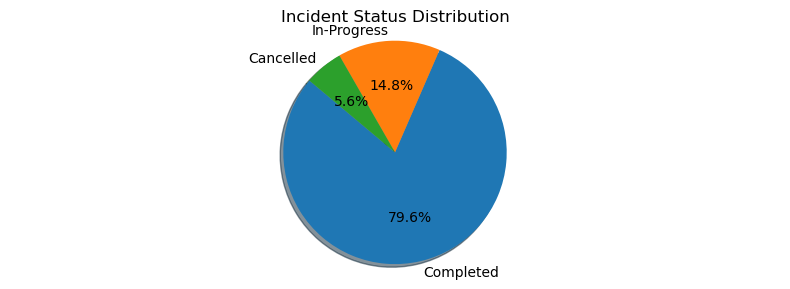

In [12]:
status_counts = raw_data_df['status'].value_counts()

plt.figure(figsize=(8, 3))
plt.pie(
status_counts,
labels=status_counts.index,
autopct='%1.1f%%',
startangle=140,
shadow=True
)
plt.title('Incident Status Distribution')
plt.axis('equal') # Ensures pie is drawn as a circle
plt.tight_layout()
plt.show()

In [13]:
raw_data_df['Priority'].value_counts()

P4    5574
P3    1042
P2     359
Name: Priority, dtype: int64

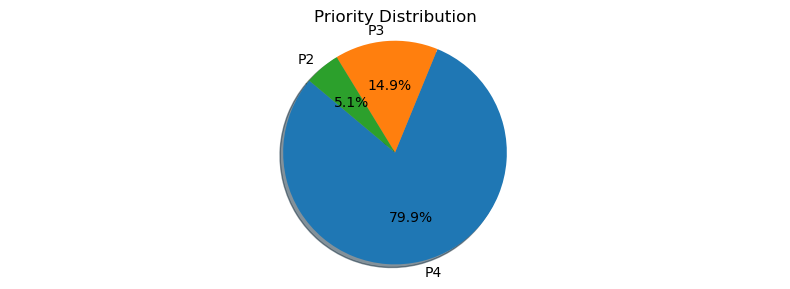

In [14]:
priority_counts = raw_data_df['Priority'].value_counts()

plt.figure(figsize=(8, 3))
plt.pie(
priority_counts,
labels=priority_counts.index,
autopct='%1.1f%%',
startangle=140,
shadow=True
)
plt.title('Priority Distribution')
plt.axis('equal') # Ensures pie is drawn as a circle
plt.tight_layout()
plt.show()

In [15]:
raw_data_df['resolution_notes'].value_counts()

Hardware: Cleaned fan assembly and updated BIOS.                  531
Database: Optimized SQL query to resolve timeout.                 486
Hardware: Replaced faulty RAM module.                             485
Access: New role permissions assigned manually.                   476
Software: Updated dependency libraries to resolve error.          472
Network: Switch firmware upgrade resolved packet loss.            472
Network: DHCP reconfiguration fixed IP allocation.                464
Software: Reinstalled software after registry clean-up.           463
Network: VPN issue resolved by resetting tunnel configuration.    462
Database: Table indexing completed to improve performance.        454
Software: Patched application resolved crash issue.               454
Hardware: Power unit replacement resolved the issue.              453
Database: Cleared blocking session and restarted job.             450
Access: Group membership updated in AD.                           427
Access: MFA reset co

# Time Series Models Creation & Training

In [16]:
time_series_df = raw_data_df[raw_data_df['status'] == 'Completed']

In [17]:
time_series_df['status'].value_counts()

Completed    5551
Name: status, dtype: int64

In [18]:
# Ensure 'created_at' is datetime
time_series_df['created_date'] = pd.to_datetime(raw_data_df['created_date'])

# Group by assignment_group and resample to monthly counts
monthly_counts = (
    time_series_df
    .groupby(['assignment_group', pd.Grouper(key='created_date', freq='MS')])
    .size()
    .reset_index(name='incident_count')
)

/tmp/ipykernel_8691/2055170968.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_series_df['created_date'] = pd.to_datetime(raw_data_df['created_date'])


06:54:44 - cmdstanpy - INFO - Chain [1] start processing
06:54:44 - cmdstanpy - INFO - Chain [1] done processing


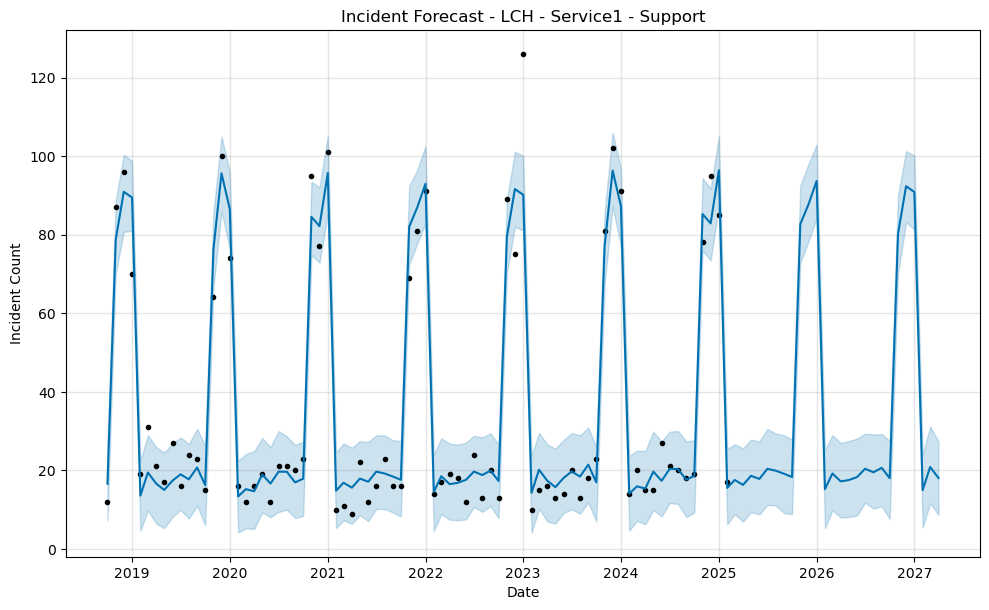

06:54:44 - cmdstanpy - INFO - Chain [1] start processing
06:54:45 - cmdstanpy - INFO - Chain [1] done processing


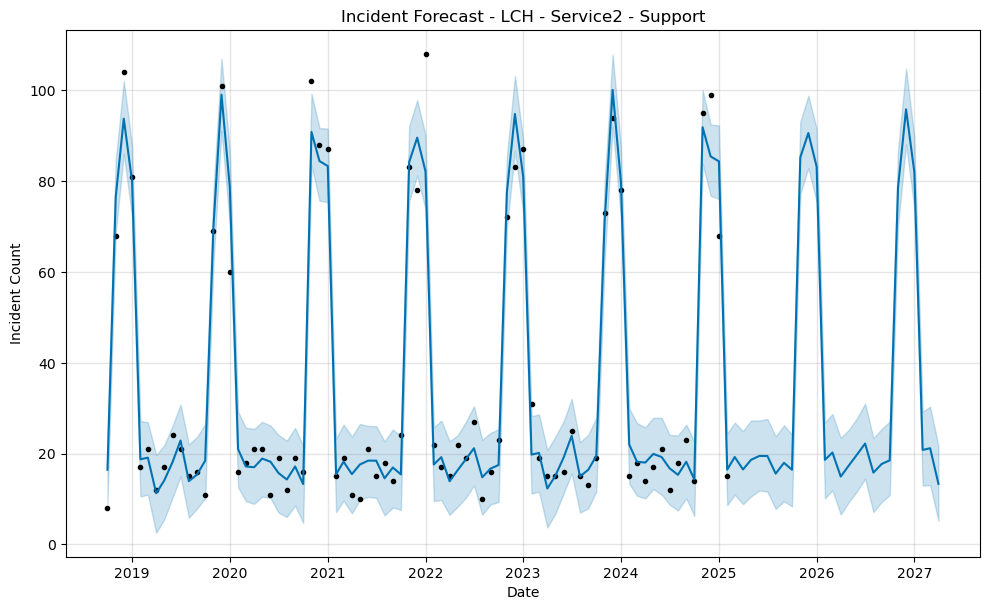

In [19]:
results = {}
future_months = 26

for group in monthly_counts['assignment_group'].unique():
    group_df = monthly_counts[monthly_counts['assignment_group'] == group]
    group_df = group_df.rename(columns={'created_date': 'ds', 'incident_count': 'y'})

    # Instantiate model with monthly seasonality
    model = Prophet()
    # model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

    # Fit model
    model.fit(group_df)

    # Predict future
    future = model.make_future_dataframe(periods=future_months, freq='MS')
    forecast = model.predict(future)

    # Save results
    results[group] = {
        'model': model,
        'forecast': forecast,
        'historic_data': group_df
    }

    # Plot
    fig = model.plot(forecast)
    plt.title(f'Incident Forecast - {group}')
    plt.xlabel('Date')
    plt.ylabel('Incident Count')
    plt.show()

In [20]:
# View forecast for a service
results['LCH - Service1 - Support']['forecast'][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

,ds,yhat,yhat_lower,yhat_upper
97,2026-11-01,80.194297,70.153614,89.941632
98,2026-12-01,92.324083,83.144112,101.255304
99,2027-01-01,90.848043,81.277883,100.158094
100,2027-02-01,14.959542,5.456954,24.098219
101,2027-03-01,20.853458,11.588318,31.150413
102,2027-04-01,18.039208,8.691853,27.305587


In [21]:
# Create a list to hold all rows for the Excel
output_rows = []

for group in monthly_counts['assignment_group'].unique():
    group_df = monthly_counts[monthly_counts['assignment_group'] == group]
    group_df = group_df.rename(columns={'created_date': 'ds', 'incident_count': 'y'})

    model = Prophet()
    model.fit(group_df)

    future = model.make_future_dataframe(periods=future_months, freq='MS')
    forecast = model.predict(future)

    # Mark actual and predicted values
    forecast['assignment_group'] = group
    forecast['type'] = ['Actual' if ds in group_df['ds'].values else 'Forecast' for ds in forecast['ds']]

    # Use actual y where available, otherwise use yhat
    merged_df = forecast[['ds', 'yhat', 'assignment_group', 'type']].copy()
    merged_df['incident_count'] = merged_df.apply(
        lambda row: group_df.loc[group_df['ds'] == row['ds'], 'y'].values[0] if row['type'] == 'Actual' else row['yhat'],
        axis=1
    )

    # Append to output
    for _, row in merged_df.iterrows():
        output_rows.append({
            'assignment_group': row['assignment_group'],
            'month': row['ds'].strftime('%Y-%m'),
            'incident_count': round(row['incident_count']),
            'type': row['type']
        })

# Convert to DataFrame
output_df = pd.DataFrame(output_rows)

# Save to Excel
output_df.to_csv('incident_forecast_output.csv', index=False)

06:54:45 - cmdstanpy - INFO - Chain [1] start processing
06:54:45 - cmdstanpy - INFO - Chain [1] done processing
06:54:45 - cmdstanpy - INFO - Chain [1] start processing
06:54:46 - cmdstanpy - INFO - Chain [1] done processing


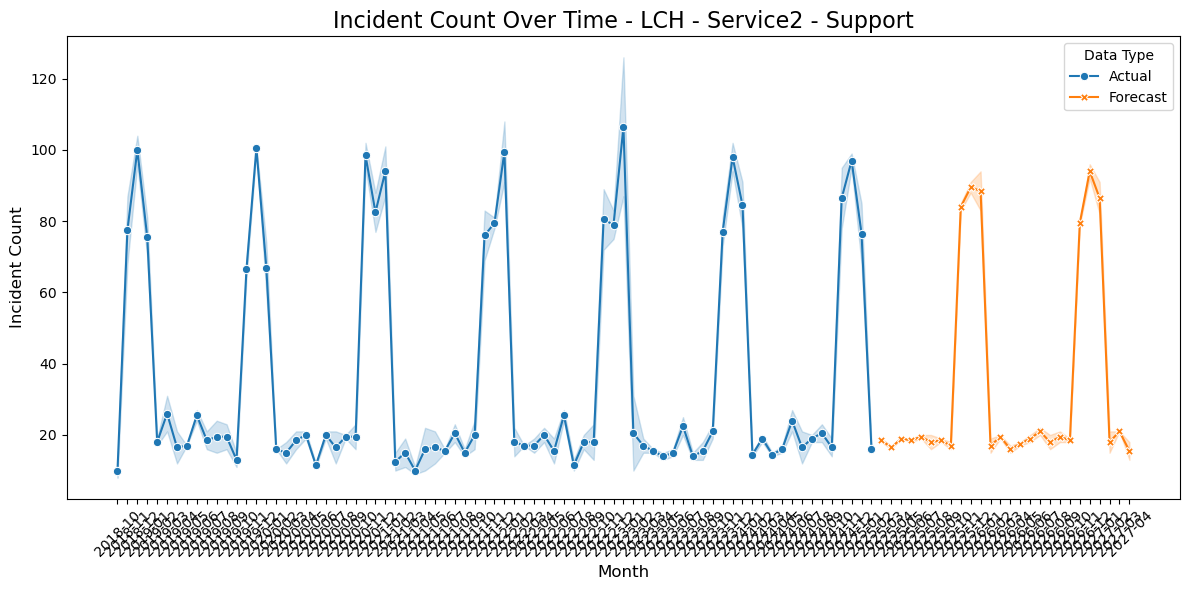

In [22]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=output_df, x='month', y='incident_count', hue='type', style='type', markers=True, dashes=False)

plt.title(f'Incident Count Over Time - {group}', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Incident Count', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Data Type')
plt.tight_layout()
plt.show()

# Resolution Notes Analysis using NLP (Natural Language Processing)

In [23]:
import pandas as pd


# Load your dataset
df = pd.read_csv("incident_dataset.csv")

# Load model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Small, fast, and accurate

# Embed resolution notes
resolution_notes = df['resolution_notes'].tolist()
embeddings = model.encode(resolution_notes, convert_to_tensor=True)

# Function to find top N similar notes
def find_similar_notes(new_note, top_n=5):
    new_embedding = model.encode([new_note], convert_to_tensor=True)
    similarities = cosine_similarity(new_embedding, embeddings)[0]
    top_indices = similarities.argsort()[-top_n:][::-1]
    similar_rows = df.iloc[top_indices][['incident_number', 'resolution_notes', 'incident_description']]
    similar_rows['similarity'] = similarities[top_indices]
    return similar_rows

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [24]:
new_note = "Application crash resolved by upgrading Java runtime."
results = find_similar_notes(new_note)
results

,incident_number,resolution_notes,incident_description,similarity
6948,INC106948,Software: Patched application resolved crash i...,IT support experienced software crash while ac...,0.761217
2,INC100002,Software: Patched application resolved crash i...,analyst experienced software crash while acces...,0.761217
6944,INC106944,Software: Patched application resolved crash i...,developer experienced software crash while acc...,0.761217
2249,INC102249,Software: Patched application resolved crash i...,IT support experienced software crash while ac...,0.761217
2306,INC102306,Software: Patched application resolved crash i...,finance user experienced software crash while ...,0.761217
